# 2 Model Benchmarking
Number of supsamples of whole dataset: 1000

In [25]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.exceptions import FitFailedWarning
import xgboost as xgb
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model


sns.set(font_scale=0.6)
warnings.filterwarnings('ignore', category=FitFailedWarning)

### Loading, sampling, scaling the data

In [2]:
# load data into df
path = 'data/Dataset-PT.csv'
df = pd.read_csv(path, header=1)

In [3]:
# create further columns, with combined variables
df['upstream_delay_incl_dwell'] = df['upstream_stop_delay'] + df['dwell_time']
df['dwell_incl_origin'] = np.abs(df['previous_bus_delay'] - df['origin_delay'])

In [4]:
# subsample the data given very long execution times for some models
df_sample = df.sample(n=1000, replace=False, random_state=42)

In [5]:
# split data into testing and training
X = df_sample[['scheduled_travel_time','previous_bus_delay','previous_trip_travel_time',
'recurrent_delay', 'upstream_delay_incl_dwell']]
y = df_sample['arrival_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Data exploration and visualisation

In [17]:
# Function which takes a model and parameters as input, finds the best set of hyperparameters,
# fits the model, and saves evaluation metrics to a DataFrame
def find_params_and_fit_model(name, model, params, output_df):
    print(f"Computing {name} model:")

    # no params to sample for linear regression
    if name == 'linear':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # else perform RandomizedSearch to sample random params and find the best ones
    else:
        random_search = RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=100,
            scoring='neg_mean_squared_error',
            cv=5, verbose=1, random_state=42, n_jobs=-1
        )

        random_search.fit(X_train, y_train)

        print("Best parameters from RandomizedSearchCV: ", random_search.best_params_)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)


    # run evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'DecisionTreeRegressor MAE: {mae:.4f}')
    print(f'DecisionTreeRegressor MSE: {mse:.4f}')
    print(f'DecisionTreeRegressor RMSE: {rmse:.4f}')
    print(f'DecisionTreeRegressor R2: {r2:.4f}')

    # plot simple predicted vs real plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
    plt.show()

    # save values in df
    output_df.loc[len(output_df)] = [
          {name},
          '-' if name == 'linear' else random_search.best_params_,
          mae,
          mse,
          rmse,
          r2
    ]

    return output_df, model if name == 'linear' else best_model

In [9]:
# Define output_df to save values in
output_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'MAE', 'MSE', 'RMSE', 'R2'])

Computing linear model:
DecisionTreeRegressor MAE: 12.2850
DecisionTreeRegressor MSE: 265.7844
DecisionTreeRegressor RMSE: 16.3029
DecisionTreeRegressor R2: 0.9953


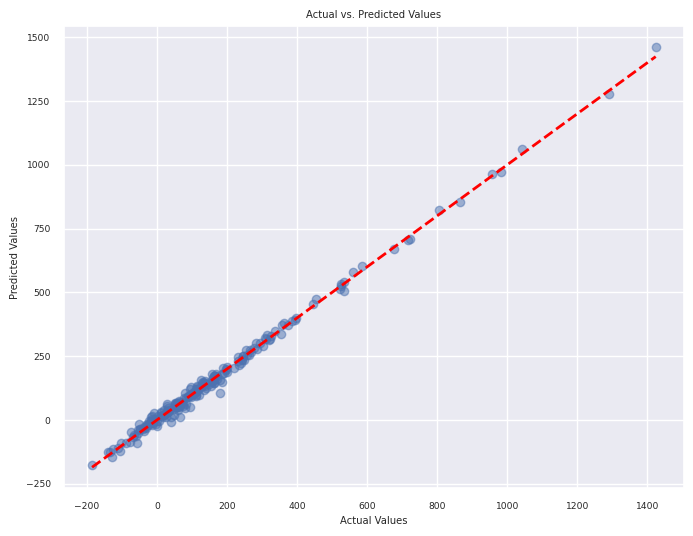

In [18]:
output_df, model_linear = find_params_and_fit_model('linear', LinearRegression(), None, output_df)

Computing Decision Tree model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [ -1803.44477213             nan  -2423.48697022  -6371.35112847
 -31326.98645149             nan             nan             nan
 -31902.08466879 -29175.38584175 -28830.33938229  -2088.39947877
  -2751.87809142 -14919.77580411  -9971.5940115   -9963.22317815
 -19533.89678517  -1665.43619792  -2369.96537922 -13702.63633543
             nan             nan  -6929.571825               nan
             nan -31160.26047167 -13653.97896215 -28830.33938229
  -9971.5940115              nan  -9682.80822917  -2088.39947877
  -8691.82941959             nan -15926.77485279  -2106.68556979
  -6003.70625     -6245.85180401 -14525.67008332 -28794.64571532
 -10559.26243685  -5025.37945445             nan             nan
             nan  -2391.92139926 -31326.98645149             nan
 -11075.78689417  -8691.82941959  -9971.5940115  -14919.77580411
  -6073.480409

Best parameters from RandomizedSearchCV:  {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'friedman_mse'}
DecisionTreeRegressor MAE: 25.0608
DecisionTreeRegressor MSE: 1217.2256
DecisionTreeRegressor RMSE: 34.8888
DecisionTreeRegressor R2: 0.9786


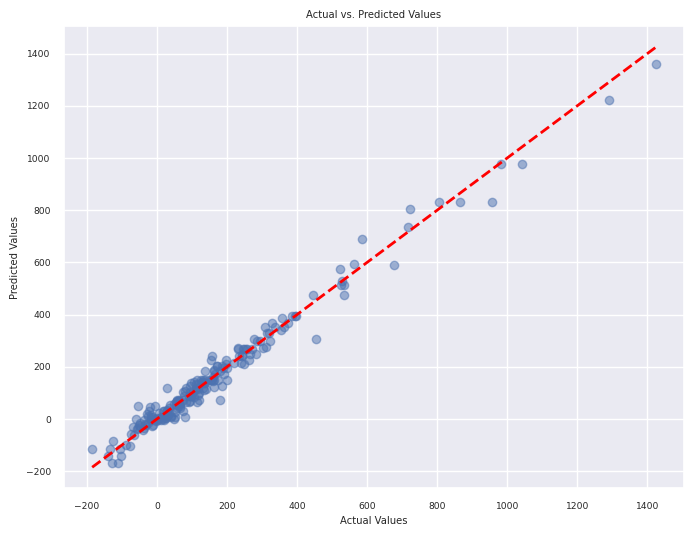

In [19]:
output_df, model_dt = find_params_and_fit_model(
    'Decision Tree',
    DecisionTreeRegressor(random_state=42),
    {
        'criterion': ["squared_error", "friedman_mse"],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 8, 24, 48, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 4, 8],
        'max_features': ['auto', 'sqrt', 'log2', None],

    },
    output_df)

Computing XGBoost model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from RandomizedSearchCV:  {'subsample': 0.75, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 4, 'eta': 0.1}
DecisionTreeRegressor MAE: 18.6496
DecisionTreeRegressor MSE: 979.7930
DecisionTreeRegressor RMSE: 31.3016
DecisionTreeRegressor R2: 0.9827


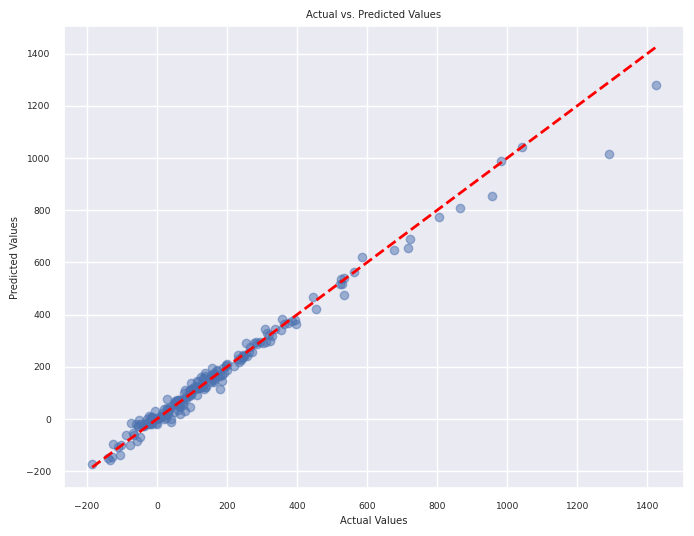

In [20]:
output_df, model_xgb = find_params_and_fit_model(
    'XGBoost',
    xgb.XGBRegressor(random_state=42),
    {
      'eta': [0.075, 0.1, 0.3],
      'gamma': [0, 2, 4, 8, 16],
      'max_depth': [2, 4, 6, 8, 24],
      'min_child_weight': [0, 1, 2],
      'subsample': [0.2, 0.75, 0.8, 1],
    },
    output_df)

Computing SVR model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from RandomizedSearchCV:  {'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'C': 2.0}
DecisionTreeRegressor MAE: 12.1344
DecisionTreeRegressor MSE: 268.3564
DecisionTreeRegressor RMSE: 16.3816
DecisionTreeRegressor R2: 0.9953


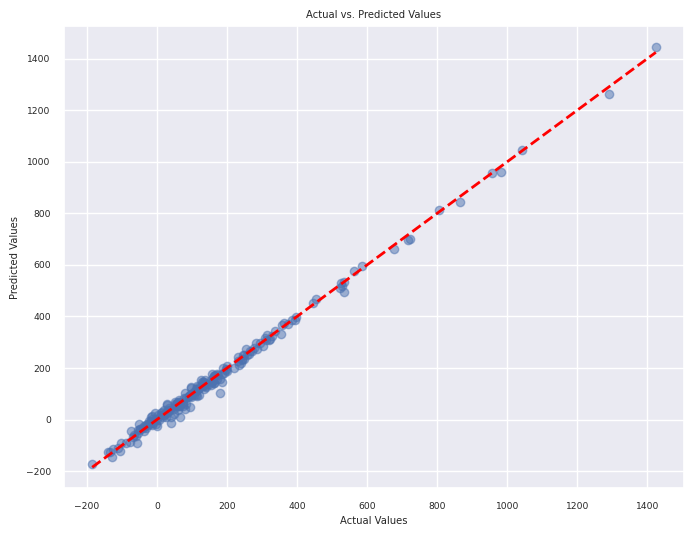

In [21]:
output_df, model_svr = find_params_and_fit_model(
    'SVR',
    SVR(),
    {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4, 5],
        'gamma': ['scale', 'auto'],
        'C': [0.2, 0.5, 1.0, 2.0]
    },
    output_df)

Computing Random Forest model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [-1292.53673841 -1301.63911462            nan            nan
 -1303.503952              nan -3885.49488326 -1301.63911462
 -2715.98268559 -2763.34084186 -2732.171119              nan
 -3088.4859                nan -1325.8189849  -2534.62328763
 -2787.41160661            nan -2763.34084186            nan
 -3756.32479062 -1301.54682462            nan -2723.02840113
            nan -1374.479475   -1324.18140597            nan
 -1430.90047439 -1304.1037185  -1301.54682462 -6546.74674167
            nan -1324.30627789 -2667.80662619 -2777.24661333
 -2814.8562855             nan -7855.45226257 -9216.71709375
 -7342.87806609 -3088.4859                nan -2667.80662619
 -2709.12571687 -2735.27981237 -1392.66975    -7342.87806609
 -3088.4859                nan            nan -1301.54682462
 -1298.42788659 -2723.02840113            nan            nan
 -622

Best parameters from RandomizedSearchCV:  {'n_estimators': 500, 'max_features': None, 'max_depth': 64, 'criterion': 'friedman_mse'}
DecisionTreeRegressor MAE: 19.2200
DecisionTreeRegressor MSE: 966.5279
DecisionTreeRegressor RMSE: 31.0890
DecisionTreeRegressor R2: 0.9830


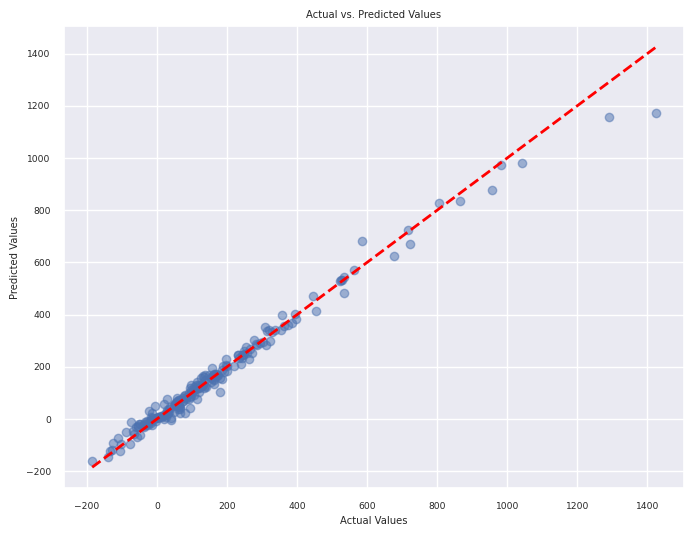

In [22]:
output_df, model_rf = find_params_and_fit_model(
    'Random Forest',
    RandomForestRegressor(random_state=42),
    {
        'n_estimators': [10, 50, 100, 200, 500],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse','poisson'],
        'max_depth': [4, 16, 64, 128, 256, None],
        'max_features': ['sqrt', 'log2', None]
    },
    output_df)

In [23]:
output_df.sort_values(by='R2', ascending=False)

,Model,Best Parameters,MAE,MSE,RMSE,R2
0,{linear},-,12.285039,265.784377,16.302895,0.995317
5,{linear},-,12.285039,265.784377,16.302895,0.995317
6,{linear},-,12.285039,265.784377,16.302895,0.995317
3,{SVR},"{'kernel': 'linear', 'gamma': 'scale', 'degree...",12.134385,268.356404,16.381587,0.995271
9,{SVR},"{'kernel': 'linear', 'gamma': 'scale', 'degree...",12.134385,268.356404,16.381587,0.995271
4,{Random Forest},"{'n_estimators': 500, 'max_features': None, 'm...",19.219970,966.527871,31.089031,0.982968
10,{Random Forest},"{'n_estimators': 500, 'max_features': None, 'm...",19.219970,966.527871,31.089031,0.982968
2,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 1, 'ma...",18.649635,979.792953,31.301645,0.982735
8,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 1, 'ma...",18.649635,979.792953,31.301645,0.982735
1,{Decision Tree},"{'splitter': 'random', 'min_samples_split': 5,...",25.060833,1217.225556,34.888760,0.978551


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


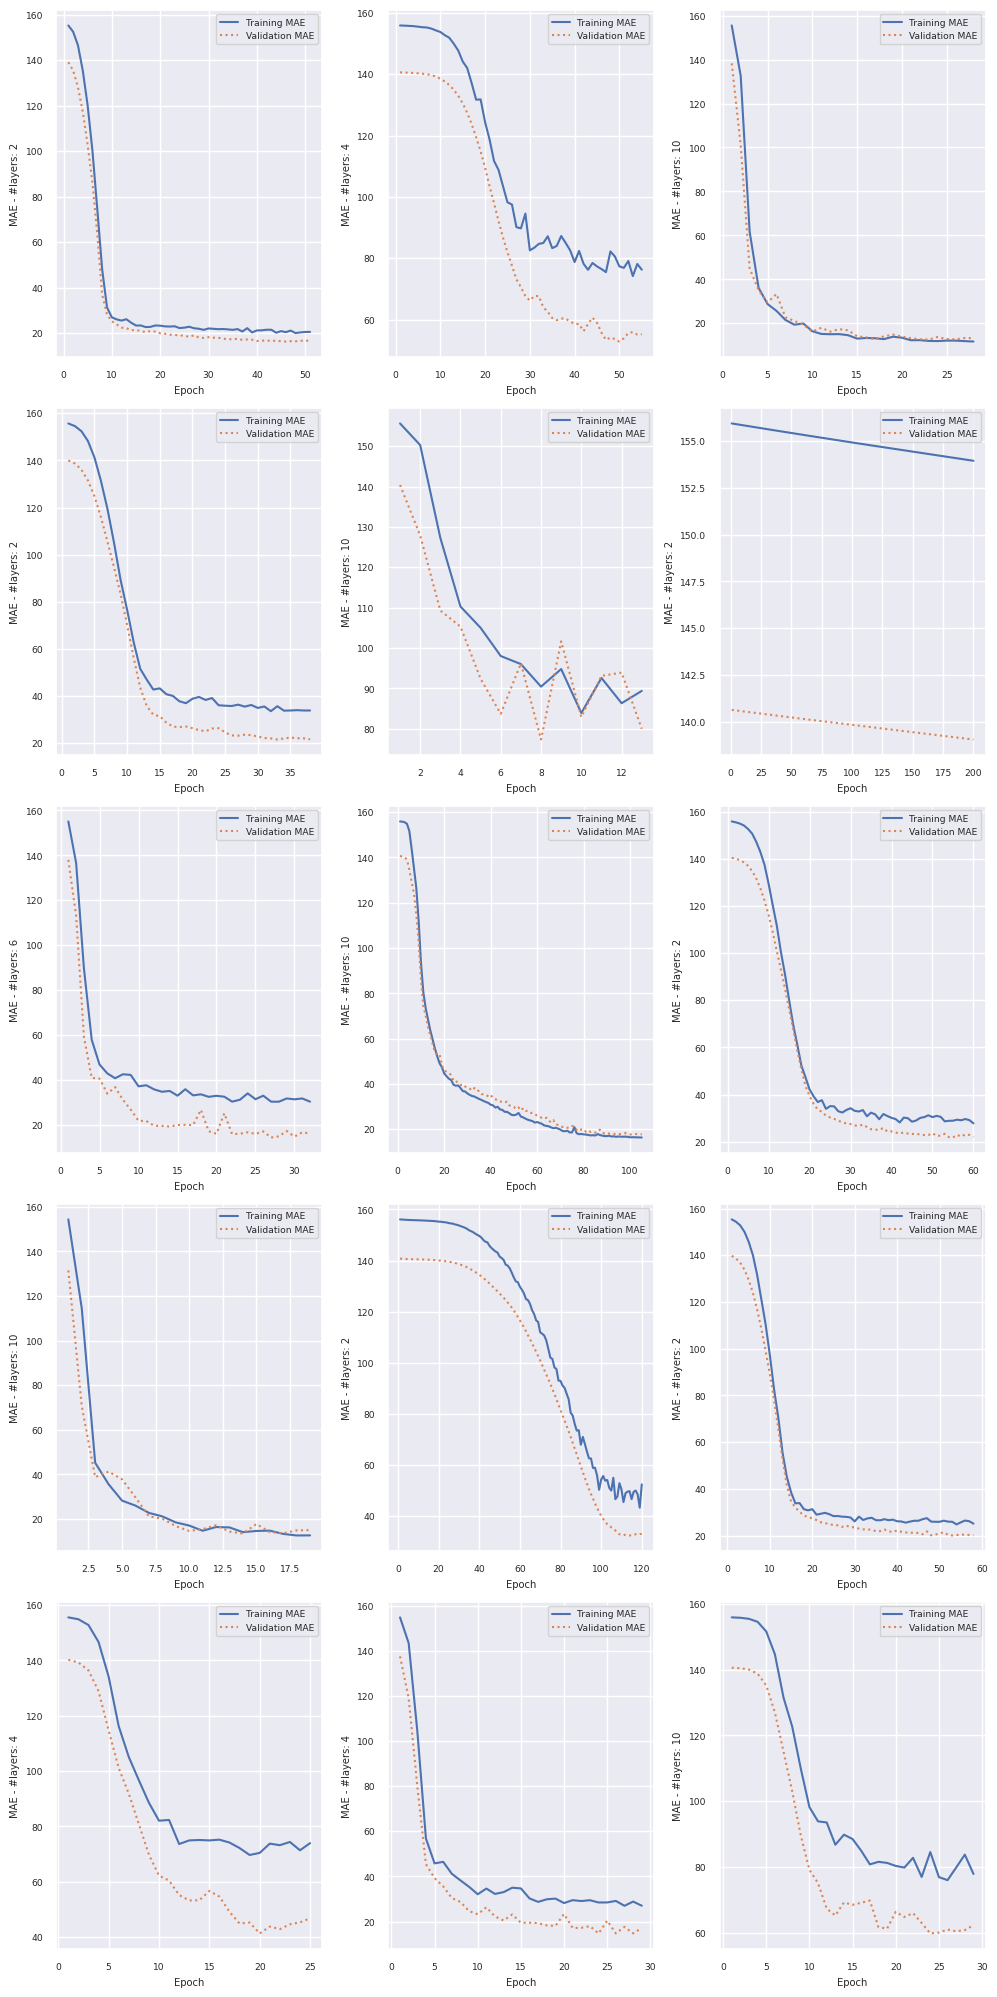

In [36]:
fig, ax = plt.subplots(5, 3, figsize=(10, 20))
output_df_nn = pd.DataFrame(columns=['n_layers', 'neuron_config', 'dropout_rate', 'MAE', 'MSE', 'R2'])

# variables to vary:
nn_params = {
    'n_layers': [2, 4, 6, 10],
    'n_neurons': [4, 8, 32, 64, 128],
    'dropout_rate': [0, 0.1, 0.2, 0.5],
}

# try 10 different random configurations
for iter in range(15):

    # randomly sample parameters
    sampled_params = dict()
    for param, vals in nn_params.items():
      sampled_params[param] = random.choice(vals)

    n_dimensions = X_train.shape[1]

    # model construction
    model = Sequential()
    neuron_config = []

    for layer in range(sampled_params['n_layers']):
      curr_n_neurons = int(sampled_params['n_neurons']*random.choice([0.5, 1, 2]))
      neuron_config.append(curr_n_neurons)

      if layer == 0:
        model.add(Dense(curr_n_neurons, activation='relu', input_dim=n_dimensions))
      else:
        model.add(Dense(curr_n_neurons, activation='relu'))

      model.add(Dropout(sampled_params['dropout_rate']))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    # model training
    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
    filepath = "weights.best.h5.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=0, save_best_only=True, mode='min')
    hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

    # model evaluation
    err = hist.history['mae']
    val_err = hist.history['val_mae']
    epochs = range(1, len(err) + 1)
    ax[int(iter/3), (iter % 3)].plot(epochs, err, '-', label='Training MAE')
    ax[int(iter/3), (iter % 3)].plot(epochs, val_err, ':', label='Validation MAE')
    ax[int(iter/3), (iter % 3)].set_xlabel('Epoch')
    ax[int(iter/3), (iter % 3)].set_ylabel('MAE - #layers: '+ str(sampled_params['n_layers']))
    ax[int(iter/3), (iter % 3)].legend(loc='upper right')

    # Use the trained model to predict on the test data.
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    output_df_nn.loc[len(output_df_nn)] = [
        sampled_params['n_layers'],
        neuron_config,
        sampled_params['dropout_rate'],
        mae,
        mse,
        r2
    ]


fig.tight_layout()

In [37]:
output_df_nn.sort_values(by='R2', ascending=False)

,n_layers,neuron_config,dropout_rate,MAE,MSE,R2
2,10,"[128, 128, 64, 128, 128, 64, 128, 32, 32, 32]",0.0,13.001136,299.504636,0.994722
9,10,"[128, 128, 128, 64, 128, 64, 32, 64, 128, 32]",0.0,13.688042,321.047125,0.994343
6,6,"[128, 64, 128, 128, 64, 128]",0.2,14.063511,343.966152,0.993939
0,2,"[128, 256]",0.2,13.980290,360.883683,0.993641
13,4,"[64, 128, 128, 128]",0.2,14.266057,363.045631,0.993603
7,10,"[4, 16, 16, 8, 4, 16, 8, 4, 4, 16]",0.0,15.352574,482.359626,0.991500
11,2,"[64, 64]",0.2,16.041394,569.821491,0.989959
3,2,"[64, 256]",0.5,17.034960,646.109143,0.988615
8,2,"[32, 64]",0.2,17.323490,684.033116,0.987946
12,4,"[16, 64, 32, 64]",0.5,38.451808,2848.865640,0.949799


In [45]:
output_df.loc[len(output_df)] = [
          {'neural net'},
          '{n_layers: 4, \
            neuron_config: [128, 128, 64, 128, 128, 64, 128, 32, 32, 32],\
            dropout_rate: 0.0}',
          13.001136,
          299.504636,
          np.sqrt(299.504636),
          0.994722
    ]

In [46]:
output_df.sort_values(by='R2', ascending=False)

,Model,Best Parameters,MAE,MSE,RMSE,R2
0,{linear},-,12.285039,265.784377,16.302895,0.995317
3,{SVR},"{'kernel': 'linear', 'gamma': 'scale', 'degree...",12.134385,268.356404,16.381587,0.995271
5,{neural net},"{n_layers: 4, neuron_config: [128,...",13.001136,299.504636,17.306202,0.994722
4,{Random Forest},"{'n_estimators': 500, 'max_features': None, 'm...",19.219970,966.527871,31.089031,0.982968
2,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 1, 'ma...",18.649635,979.792953,31.301645,0.982735
1,{Decision Tree},"{'splitter': 'random', 'min_samples_split': 5,...",25.060833,1217.225556,34.888760,0.978551
